In [1]:
!pip install -U gensim

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc,classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
spam_data = pd.read_csv('spam_home_kitchen.csv')
test_data = pd.read_csv('test_spam_home_kitchen.csv')

In [4]:
spam_data.head()

,Unnamed: 0,Processed Text,class
0,0,recommend great chef test cook cooking tool ea...,1.0
1,1,great pump work perfectly happy purchase thank...,1.0
2,2,beauty function saw pattern online corelle sco...,1.0
3,3,red neck wine glass wonderful use wedding toas...,1.0
4,4,stay away handle body make cheap plastic never...,0.0


In [5]:
class_0 = spam_data[spam_data['class']==0.]
print(len(spam_data))
print(len(class_0))
class_1 = spam_data[spam_data['class']==1.]
print(len(class_1))
class_1 = class_1.sample(n = len(class_0))
print(len(class_1))
class_1

13960
2865
11095
2865


,Unnamed: 0,Processed Text,class
6746,6746,pretty thin king bed get king size duvet turn ...,1.0
2398,2398,great product easy use great job exracting jui...,1.0
4179,4179,great rv home bought use rv since draw watt pu...,1.0
2491,2491,great value price expect much spresso machine ...,1.0
196,196,work advertised problem work terrific cautious...,1.0
...,...,...,...
8496,8496,herb keeper wife love item specifically look s...,1.0
3101,3101,beautiful useful fan live e texas hurricane al...,1.0
11098,11098,great protect book cooking holder great keep s...,1.0
7863,7863,use daily use daily work never sweat keep drin...,1.0


In [6]:
reb_data = pd.concat((class_0,class_1)).reset_index(drop=True)

In [7]:
X_train = reb_data['Processed Text']
Y_train = reb_data['class']

In [8]:
class_0 = test_data[test_data['class']==0.]
class_1 = test_data[test_data['class']==1.]
class_1 = class_1.sample(n = len(class_0))

In [9]:
test_reb_data = pd.concat((class_0,class_1)).reset_index(drop=True)

In [10]:
X_test = test_reb_data['Processed Text']
Y_test = test_reb_data['class']

Word2Vec

In [11]:
words_in_sentences=[]
for i in tqdm(X_train):
    words_in_sentences.append(i.split())

100%|██████████████████████████████████████████████████████████████████████████| 5730/5730 [00:00<00:00, 150803.24it/s]


In [12]:
model = Word2Vec(sentences=words_in_sentences,vector_size = 300)

In [13]:
#Total number of words in the Vocabulary on which the Word2Vec model is trained.
vocab=list(model.wv.key_to_index.keys())
print(len(vocab))

3647


In [14]:
#Average Word2Vec is a technique in which the average of word embeddings of all the words given in a sentence is used as the numerical vector for a given sentence.
def avg_w2vec(sentences):
    transformed=[]
    for sentence in tqdm(sentences):
        count=0
        vector=np.zeros(300)
        for word in sentence.split():
            if word in vocab:
                vector+=model.wv.get_vector(word)
                count+=1
        if count!=0:
            vector/=count
            transformed.append(vector)
        else:
            print(sentence)
    return np.array(transformed)

In [15]:
x_train_transformed=avg_w2vec(X_train)
x_test_transformed=avg_w2vec(X_test)

100%|████████████████████████████████████████████████████████████████████████████| 2502/2502 [00:02<00:00, 1032.34it/s]


In [16]:
#Using K-Nearest Neighbors Algorithm to predict whether a given review is Spam or not
grid_params = { 'n_neighbors' : [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80],
               'metric' : ['manhattan']}
knn=KNeighborsClassifier()
clf = RandomizedSearchCV(knn, grid_params, random_state=0,n_jobs=-1,verbose=1)
clf.fit(x_train_transformed,Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'metric': ['manhattan'],
                                        'n_neighbors': [5, 10, 15, 20, 25, 30,
                                                        35, 40, 45, 50, 55, 60,
                                                        65, 70, 75, 80]},
                   random_state=0, verbose=1)

In [17]:
clf.best_params_

{'n_neighbors': 55, 'metric': 'manhattan'}

In [18]:
clf.best_score_

0.6356020942408377

In [19]:
clf.cv_results_

{'mean_fit_time': array([0.02578492, 0.0307817 , 0.03138161, 0.03038259, 0.03238153,
        0.0327806 , 0.03438058, 0.03238149, 0.03198085, 0.03537879]),
 'std_fit_time': array([0.00159895, 0.00116507, 0.00195858, 0.0020583 , 0.00162308,
        0.0023993 , 0.00422087, 0.00079944, 0.00316025, 0.0066472 ]),
 'mean_score_time': array([6.08490763, 6.0813098 , 6.00575337, 5.9108068 , 6.04852834,
        5.95078506, 5.93259387, 6.02574039, 5.86783233, 4.73588514]),
 'std_score_time': array([0.18245385, 0.21867338, 0.10924387, 0.11154355, 0.12634847,
        0.12296038, 0.12042146, 0.06777695, 0.06653819, 1.16536486]),
 'param_n_neighbors': masked_array(data=[10, 35, 45, 50, 70, 25, 15, 75, 55, 40],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_metric': masked_array(data=['manhattan', 'manhattan', 'manhattan', 'manhattan',
                    'manhattan', 'manhattan',

In [20]:
train_fpr,train_tpr,thresholds=roc_curve(Y_train,clf.predict_proba(x_train_transformed)[:,1])
test_fpr,test_tpr,thresholds=roc_curve(Y_test,clf.predict_proba(x_test_transformed)[:,1])

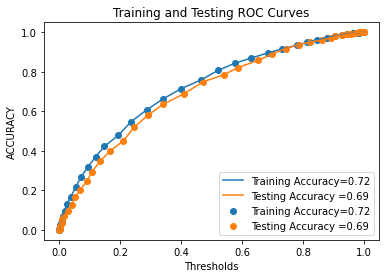

In [21]:

plt.plot(train_fpr,train_tpr,label="Training Accuracy="+str(round(auc(train_fpr, train_tpr),2)))
plt.plot(test_fpr,test_tpr,label="Testing Accuracy ="+str(round(auc(test_fpr, test_tpr),2)))
plt.scatter(train_fpr,train_tpr,label="Training Accuracy="+str(round(auc(train_fpr, train_tpr),2)))
plt.scatter(test_fpr,test_tpr,label="Testing Accuracy ="+str(round(auc(test_fpr, test_tpr),2)))
plt.legend()
plt.xlabel("Thresholds")
plt.ylabel("ACCURACY")
plt.title("Training and Testing ROC Curves")
plt.show()

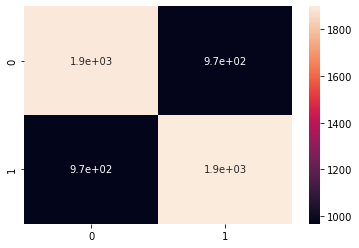

In [22]:
sns.heatmap(confusion_matrix(Y_train,clf.predict(x_train_transformed)),annot=True)
plt.show()

In [23]:
print(classification_report(Y_train,clf.predict(x_train_transformed)))

              precision    recall  f1-score   support

         0.0       0.66      0.66      0.66      2865
         1.0       0.66      0.66      0.66      2865

    accuracy                           0.66      5730
   macro avg       0.66      0.66      0.66      5730
weighted avg       0.66      0.66      0.66      5730



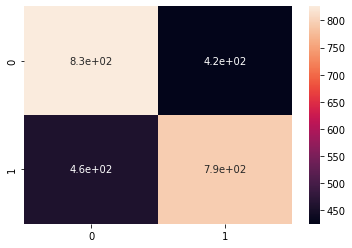

In [24]:
sns.heatmap(confusion_matrix(Y_test,clf.predict(x_test_transformed)),annot=True)
plt.show()

In [25]:
print(classification_report(Y_test,clf.predict(x_test_transformed)))

              precision    recall  f1-score   support

         0.0       0.64      0.66      0.65      1251
         1.0       0.65      0.63      0.64      1251

    accuracy                           0.65      2502
   macro avg       0.65      0.65      0.65      2502
weighted avg       0.65      0.65      0.65      2502



In [26]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

svc = SVC(kernel = 'sigmoid', gamma = 1.0)
svc.fit(x_train_transformed, Y_train)

Y_pred = svc.predict(x_test_transformed)
accuracy_score(Y_test, Y_pred)

0.504396482813749